# maxsmi
## Analysis of results

This notebook serves to analyse the results of the simulations ran on the Curta cluster.

## Prerequisites
This notebook will run under the condition that some simulations have been run, e.g.
```
(maxsmi) $ python maxsmi/full_workflow.py --task ESOL --string-encoding smiles --aug-strategy-train augmentation_with_duplication --aug-strategy-test augmentation_with_duplication --aug-nb-train 10 --aug-nb-test 10 --ml-model CONV1D --eval-strategy True
```

Have a look at the [README](https://github.com/t-kimber/maxsmi/blob/main/README.md) page for more details.

In [1]:
# !pip install flake8 pycodestyle_magic
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

from rdkit import Chem
from rdkit.Chem import PandasTools, rdchem

from utils_analysis import load_results
from utils_smiles import get_num_heavy_atoms

## Ensemble learning results
Here we load the data which contains relevant information if there was augmentation on the test set, such as
- confidence of the prediction: is the standard deviation low or high?
- the absolute error between the true value and the average value

This data represents _only_ the test set (20%) and not the full data (100%). It contains most relevant information.

In [3]:
TASK = "ESOL"
STRING_ENCODING = "smiles"
TRAIN_AUGMENTATION = 70
TEST_AUGMENTATION = 70
AUGMENTATION_STRATEGY_TRAIN = "augmentation_with_reduced_duplication"
AUGMENTATION_STRATEGY_TEST = "augmentation_with_reduced_duplication"
ML_MODEL = "CONV1D"

In [4]:
test_data = load_results(TASK,
                         AUGMENTATION_STRATEGY_TRAIN,
                         TRAIN_AUGMENTATION,
                         AUGMENTATION_STRATEGY_TEST,
                         TEST_AUGMENTATION,
                         ML_MODEL,
                         STRING_ENCODING,
                         True)
test_data.head(10)

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction
181,-8.600,CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1,"[c1cc(ccc1OCC)C(C)(COCc1cc(ccc1)Oc1ccccc1)C, C...","[c1cc(ccc1OCC)C(C)(COCc1cc(ccc1)Oc1ccccc1)C, C...",-6.570059,0.529988
277,-0.600,CCS,"[C(C)S, C(C)S, C(C)S, C(C)S, SCC, SCC, SCC, SC...","[C(C)S, C(C)S, C(C)S, C(C)S, SCC, SCC, SCC, SC...",-0.735204,0.098035
125,-0.600,CC(=O)OCC(COC(C)=O)OC(C)=O,"[C(C(OC(C)=O)COC(C)=O)OC(=O)C, C(C(COC(C)=O)OC...","[C(C(OC(C)=O)COC(C)=O)OC(=O)C, C(C(COC(C)=O)OC...",-0.901669,0.296972
937,-0.670,CCC(C)C(C)=O,"[C(CC)(C)C(C)=O, C(C(=O)C)(C)CC, C(C(=O)C)(C)C...","[C(CC)(C)C(C)=O, C(C(=O)C)(C)CC, C(C(=O)C)(C)C...",-0.805345,0.258695
444,-5.050,C=CCCCCCCC,"[C(CC=C)CCCCC, C(CC=C)CCCCC, C=CCCCCCCC, C=CCC...","[C(CC=C)CCCCC, C(CC=C)CCCCC, C=CCCCCCCC, C=CCC...",-4.922393,0.113186
780,-8.000,c1ccc2c3c(ccc2c1)-c1cccc2cccc-3c12,"[c1cccc2ccc3c(-c4c5c(cccc5-3)ccc4)c21, c12c3c(...","[c1cccc2ccc3c(-c4c5c(cccc5-3)ccc4)c21, c12c3c(...",-7.942853,0.450876
405,-4.630,CC(=O)OCC(=O)C1CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C,[C12CCC3(C(CCC3C(=O)COC(=O)C)C1CCC1=CC(CCC21C)...,[C12CCC3(C(CCC3C(=O)COC(=O)C)C1CCC1=CC(CCC21C)...,-4.695426,0.452661
1111,-5.190,O=C1c2ccccc2C(=O)c2ccccc21,"[c12ccccc2C(c2ccccc2C1=O)=O, c12c(C(c3ccccc3C1...","[c12ccccc2C(c2ccccc2C1=O)=O, c12c(C(c3ccccc3C1...",-3.784492,0.389990
83,-2.770,Cc1ccc(C)cc1,"[c1c(ccc(C)c1)C, c1c(ccc(C)c1)C, Cc1ccc(C)cc1,...","[c1c(ccc(C)c1)C, c1c(ccc(C)c1)C, Cc1ccc(C)cc1,...",-2.853631,0.074339
863,-4.925,C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O,"[C(C1(C(N(c2cc(cc(c2)Cl)Cl)C(=O)O1)=O)C)=C, C1...","[C(C1(C(N(c2cc(cc(c2)L)L)C(=O)O1)=O)C)=C, C1(O...",-3.637046,0.522264


## Load the counterpart with no augmentation

In [5]:
test_data_no_aug = load_results(TASK,
                                AUGMENTATION_STRATEGY_TRAIN,
                                0,
                                AUGMENTATION_STRATEGY_TEST,
                                0,
                                ML_MODEL,
                                STRING_ENCODING,
                                True)
test_data_no_aug.head()

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction
181,-8.60,CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1,[CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1],[CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1],-6.521006,0.0
277,-0.60,CCS,[CCS],[CCS],-0.839207,0.0
125,-0.60,CC(=O)OCC(COC(C)=O)OC(C)=O,[CC(=O)OCC(COC(C)=O)OC(C)=O],[CC(=O)OCC(COC(C)=O)OC(C)=O],0.230203,0.0
937,-0.67,CCC(C)C(C)=O,[CCC(C)C(C)=O],[CCC(C)C(C)=O],-1.815931,0.0
444,-5.05,C=CCCCCCCC,[C=CCCCCCCC],[C=CCCCCCCC],-4.811691,0.0


In [6]:
test_data_no_aug = test_data_no_aug.rename(columns={"average_\
prediction": "prediction"})

In [7]:
data = pd.concat([test_data, test_data_no_aug["prediction"]], axis=1)
data

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction,prediction
181,-8.600,CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1,"[c1cc(ccc1OCC)C(C)(COCc1cc(ccc1)Oc1ccccc1)C, C...","[c1cc(ccc1OCC)C(C)(COCc1cc(ccc1)Oc1ccccc1)C, C...",-6.570059,0.529988,-6.521006
277,-0.600,CCS,"[C(C)S, C(C)S, C(C)S, C(C)S, SCC, SCC, SCC, SC...","[C(C)S, C(C)S, C(C)S, C(C)S, SCC, SCC, SCC, SC...",-0.735204,0.098035,-0.839207
125,-0.600,CC(=O)OCC(COC(C)=O)OC(C)=O,"[C(C(OC(C)=O)COC(C)=O)OC(=O)C, C(C(COC(C)=O)OC...","[C(C(OC(C)=O)COC(C)=O)OC(=O)C, C(C(COC(C)=O)OC...",-0.901669,0.296972,0.230203
937,-0.670,CCC(C)C(C)=O,"[C(CC)(C)C(C)=O, C(C(=O)C)(C)CC, C(C(=O)C)(C)C...","[C(CC)(C)C(C)=O, C(C(=O)C)(C)CC, C(C(=O)C)(C)C...",-0.805345,0.258695,-1.815931
444,-5.050,C=CCCCCCCC,"[C(CC=C)CCCCC, C(CC=C)CCCCC, C=CCCCCCCC, C=CCC...","[C(CC=C)CCCCC, C(CC=C)CCCCC, C=CCCCCCCC, C=CCC...",-4.922393,0.113186,-4.811691
...,...,...,...,...,...,...,...
441,-0.244,OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O,"[O1C(CO)C(O)C(O)C(O)C1OC1C(OC(O)C(O)C1O)CO, C1...","[O1C(CO)C(O)C(O)C(O)C1OC1C(OC(O)C(O)C1O)CO, C1...",0.662369,0.219136,0.301161
39,-4.810,CCCCCCCI,"[C(CCI)CCCC, C(CCI)CCCC, C(CCI)CCCC, C(I)CCCCC...","[C(CCI)CCCC, C(CCI)CCCC, C(CCI)CCCC, C(I)CCCCC...",-4.739038,0.167620,-4.352878
943,-1.520,c1ccc2[nH]ccc2c1,"[c1c2c([nH]c1)cccc2, c1cc2[nH]ccc2cc1, c1cc2[n...","[c1c2c([nH]c1)cccc2, c1cc2[nH]ccc2cc1, c1cc2[n...",-2.978008,0.319472,-2.831413
512,-2.420,Cc1c[nH]c2ccccc12,"[c12[nH]cc(c2cccc1)C, Cc1c[nH]c2c1cccc2, c1[nH...","[c12[nH]cc(c2cccc1)C, Cc1c[nH]c2c1cccc2, c1[nH...",-3.123561,0.376012,-3.084671


## Size of molecules

In [8]:
data["num_heavy_atoms"] = data["canonical_\
smiles"].apply(get_num_heavy_atoms)

## Difference in prediction error with and without augmentation

In [9]:
for index in data.index:
    aug_error = np.absolute(
        data.loc[index]["target"] -
        data.loc[index]["average_prediction"]
    )
    data.loc[index,
             "average_error"] = aug_error
    no_aug_error = np.absolute(
        data.loc[index]["target"] -
        data.loc[index]["prediction"]
    )
    data.loc[index,
             "no_aug_error"] = no_aug_error

In [10]:
data.head(3)

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction,prediction,num_heavy_atoms,average_error,no_aug_error
181,-8.6,CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1,"[c1cc(ccc1OCC)C(C)(COCc1cc(ccc1)Oc1ccccc1)C, C...","[c1cc(ccc1OCC)C(C)(COCc1cc(ccc1)Oc1ccccc1)C, C...",-6.570059,0.529988,-6.521006,28,2.029941,2.078994
277,-0.6,CCS,"[C(C)S, C(C)S, C(C)S, C(C)S, SCC, SCC, SCC, SC...","[C(C)S, C(C)S, C(C)S, C(C)S, SCC, SCC, SCC, SC...",-0.735204,0.098035,-0.839207,3,0.135204,0.239207
125,-0.6,CC(=O)OCC(COC(C)=O)OC(C)=O,"[C(C(OC(C)=O)COC(C)=O)OC(=O)C, C(C(COC(C)=O)OC...","[C(C(OC(C)=O)COC(C)=O)OC(=O)C, C(C(COC(C)=O)OC...",-0.901669,0.296972,0.230203,15,0.301669,0.830203


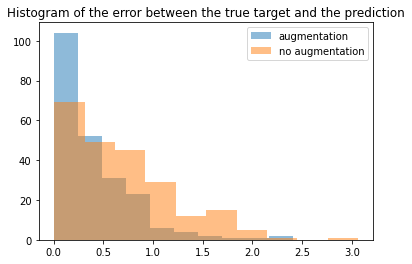

In [11]:
plt.hist(data["average_error"], alpha=0.5)
plt.hist(data["no_aug_error"], alpha=0.5)
plt.legend(["augmentation", "no augmentation"])
plt.title("Histogram of the error between the true target and the prediction")
plt.show()

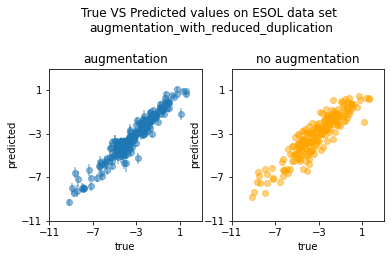

In [12]:
total_min = min(data['target'].min(),
                data['average_prediction'].min())
total_max = max(data['target'].max(),
                data['average_prediction'].max())

fig, ax = plt.subplots(nrows=1,
                       ncols=2,)
x = data["target"]
y = data["average_prediction"]
err = data["std_prediction"]

ax[0].errorbar(x, y, yerr=err, fmt='o', alpha=0.5)
ax[1].scatter(x, data["prediction"], alpha=0.5, color="orange")

for i, axis in enumerate(ax):
    ax[i].set_xticks(np.arange(np.floor(total_min-1), np.ceil(total_max+1), 4))
    ax[i].set_yticks(np.arange(np.floor(total_min-1), np.ceil(total_max+1), 4))
    ax[i].set_xlim(np.floor(total_min-1), np.ceil(total_max+1))
    ax[i].set_ylim(np.floor(total_min-1), np.ceil(total_max+1))
    ax[i].set_xlabel("true")
    ax[i].set_ylabel("predicted")
    ax[i].set_aspect("equal", adjustable="box")

ax[0].set_title("augmentation")
ax[1].set_title("no augmentation")

fig.suptitle(f"True VS Predicted values on {TASK} data set \n"
             f"{AUGMENTATION_STRATEGY_TEST}")

plt.show()

### Visualize the molecules

In [13]:
def ensemble_learning_metric(data, metric="min", num=3,
                             augmentation_strategy=AUGMENTATION_STRATEGY_TEST):
    """
    Return the rdkit molecule object with `metric` standard deviation.

    Parameters
    ----------
    data : pd.Pandas
        # TODO
    metric : str
        The metric to consider for the standard deviation of the prediction.
    num : int
        The top n `num` entries to consider.
    augmentation_strategy : # TODO

    Returns
    -------
    tuple
        target, canonical SMILES, random SMILES, RDKit molecule.
    """

    print("Augmentation strategy: ", augmentation_strategy)
    print("\n")
    if metric == "min":
        selection = data.nsmallest(num, 'std_prediction', keep="all")
    if metric == "max":
        selection = data.nlargest(num, 'std_prediction', keep="all")

    for index in selection.index:
        canonical_smile = data.loc[index]["canonical_smiles"]
        mol = Chem.MolFromSmiles(canonical_smile)
        random_smiles = data.loc[index]["augmented_smiles"]
        target = data.loc[index]["target"]
        average_prediction = data.loc[index]['average_prediction']
        absolute_error = data.loc[index]["average_error"]
        no_aug_error = data.loc[index]["no_aug_error"]
        standard_deviation_prediction = data.loc[index,
                                                 "std_prediction"]

        PandasTools.AddMoleculeColumnToFrame(selection,
                                             smilesCol='canonical_smiles')
    return selection

Augmentation strategy:  augmentation_with_reduced_duplication




,average_error,no_aug_error,std_prediction,canonical_smiles,ROMol
835,0.22,0.77,0.00,c1ccccc1,
1068,0.32,0.81,0.04,CCCC,
108,0.31,0.75,0.04,CC(C)C,

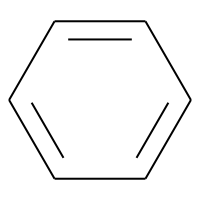
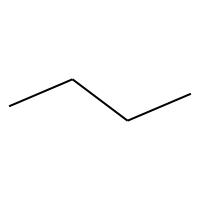
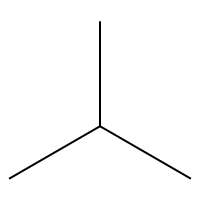

In [14]:
high_confidence_mol = ensemble_learning_metric(data=data, metric="min")
high_confidence_mol[["average_error",
                     "no_aug_error",
                     "std_prediction",
                     "canonical_smiles",
                     "ROMol"]].style.format({"average_error": "{:.2f}",
                                             "no_aug_error": "{:.2f}",
                                             "std_prediction": "{:.2f}", })

Augmentation strategy:  augmentation_with_reduced_duplication




,average_error,no_aug_error,std_prediction,canonical_smiles,ROMol
450,0.13,0.14,0.19,Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)Cl)cc1,
441,0.91,0.55,0.22,OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O,
894,0.78,0.98,0.23,CC(C)Nc1nc(Cl)nc(NC(C)C)n1,
282,0.75,0.22,0.26,CC(C)C1(C(C)C)C(=O)NC(=O)NC1=O,
783,0.04,0.72,0.26,CCCCCCCCCCCCCCO,

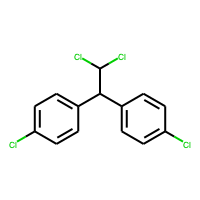
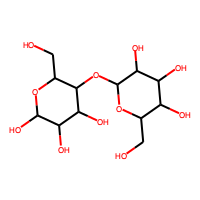
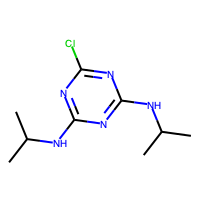
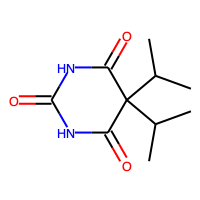
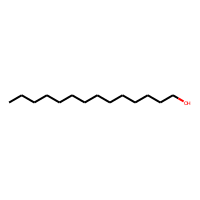

In [15]:
high_confidence_mol = ensemble_learning_metric(
    data[data["num_heavy_atoms"] >= 15],
    metric="min",
    num=5)
high_confidence_mol[["average_error",
                     "no_aug_error",
                     "std_prediction",
                     "canonical_smiles",
                     "ROMol"]].style.format({"average_error": "{:.2f}",
                                             "no_aug_error": "{:.2f}",
                                             "std_prediction": "{:.2f}", })

Augmentation strategy:  augmentation_with_reduced_duplication




,average_error,no_aug_error,std_prediction,canonical_smiles,ROMol
922,1.78,1.84,0.83,O=C1NC(=O)C2C3C(C(O)(c4ccccc4)c4ccccn4)=CC(C3=C(c3ccccc3)c3ccccn3)C12,
330,0.74,0.38,0.79,CC(C)OP(=S)(OC(C)C)SCCNS(=O)(=O)c1ccccc1,
272,1.26,0.84,0.73,CC1(C)C(C=C(Br)Br)C1C(=O)OC(C#N)c1cccc(Oc2ccccc2)c1,
622,0.57,1.82,0.64,Cn1cc(-c2ccccc2)c(=O)c(-c2cccc(C(F)(F)F)c2)c1,
373,0.28,0.83,0.64,Cc1ccccc1N1C(=O)c2cc(S(N)(=O)=O)c(Cl)cc2NC1C,

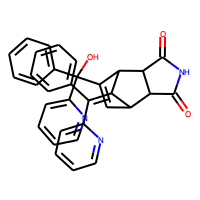
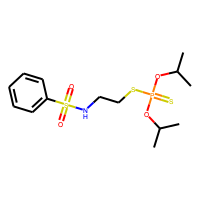
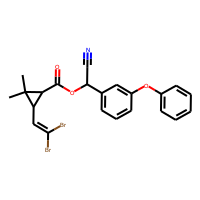
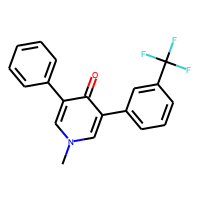
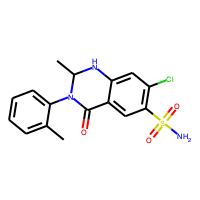

In [16]:
low_confidence_mol = ensemble_learning_metric(
    data[data["num_heavy_atoms"] >= 15],
    metric="max",
    num=5)
low_confidence_mol[["average_error",
                    "no_aug_error",
                    "std_prediction",
                    "canonical_smiles",
                    "ROMol"]].style.format({"average_error": "{:.2f}",
                                            "no_aug_error": "{:.2f}",
                                            "std_prediction": "{:.2f}", })